# House Pricing Prediction
<ul>
    <li><a href="#introduction">I - Introduction</a></li>
    <li><a href="#exploring_datas">II - Exploring datas</a></li>
    <ul>
        <li><a href="#loading_datas">1. Loading the datas</a></li>
        <li><a href="#sale_price">2. Sale Price</a></li>
        <li><a href="#missing_datas">3. Missing datas</a></li>
    </ul>
</ul>

## I - Introduction<a id="introduction"></a>

### Competition Description

<p style="text-align:justify">Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.</p>
<p style="text-align:justify">With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.</p>

### Practice Skills

<ul>
    <li>Creative feature engineering </li>
    <li>Advanced regression techniques like random forest and gradient boosting</li>
</ul>

### Goal

<p style="text-align:justify">It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.</p>

### Metric

<p style="text-align:justify">Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)</p>

### Submission File Format
The file should contain a header and have the following format:

<p class="alert alert-info">
Id,SalePrice<br>
1461,169000.1<br>
1462,187724.1233<br>
1463,175221<br>
etc.</p>

## II - Exploring the datas<a id="exploring_datas"></a>

### Loading the datas<a id="loading_datas"></a>
First of all, let's take a look at what are the datas contained in this dataset. We import a few librarires which will be usefull to exploit these datas.

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import scipy.stats as st

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
train_df = pd.read_csv("datas/train.csv")
test_df = pd.read_csv("datas/test.csv")
full = (train_df, test_df)
full_df = pd.concat([train_df, test_df])

In [74]:
display(train_df.head())
print("The shape of the train dataset is {}".format(train_df.shape))
print("The shape of the test dataset is {}".format(test_df.shape))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The shape of the train dataset is (1460, 81)
The shape of the test dataset is (1459, 80)


In [75]:
for dataset in full:
    dataset.drop(["Id"], axis=1, inplace=True)

<p style="text-align:justify">I started by dropping the ID, because it is not an interesting feature for our predictions. As we can see we have 1460 training datas and 1459 test datas. After dropping the ID, we have 79 features to describe the houses. In the train dataset, we also have the price of the house. Our goal is to train an algorithm using the train dataset to then predict the prices of the houses in the test dataset with the best accuracy.<br>We have a lot of features, so we need to look at this problem with method.</p>

### Most Important features

In [90]:
non_obj_features = [col for col in train_df.columns if train_df[col].dtype != "object"]
print("We can determine the correlation of {} features with the SalePrice.".format(len(non_obj_features)))

We can determine the correlation of 37 features with the SalePrice.


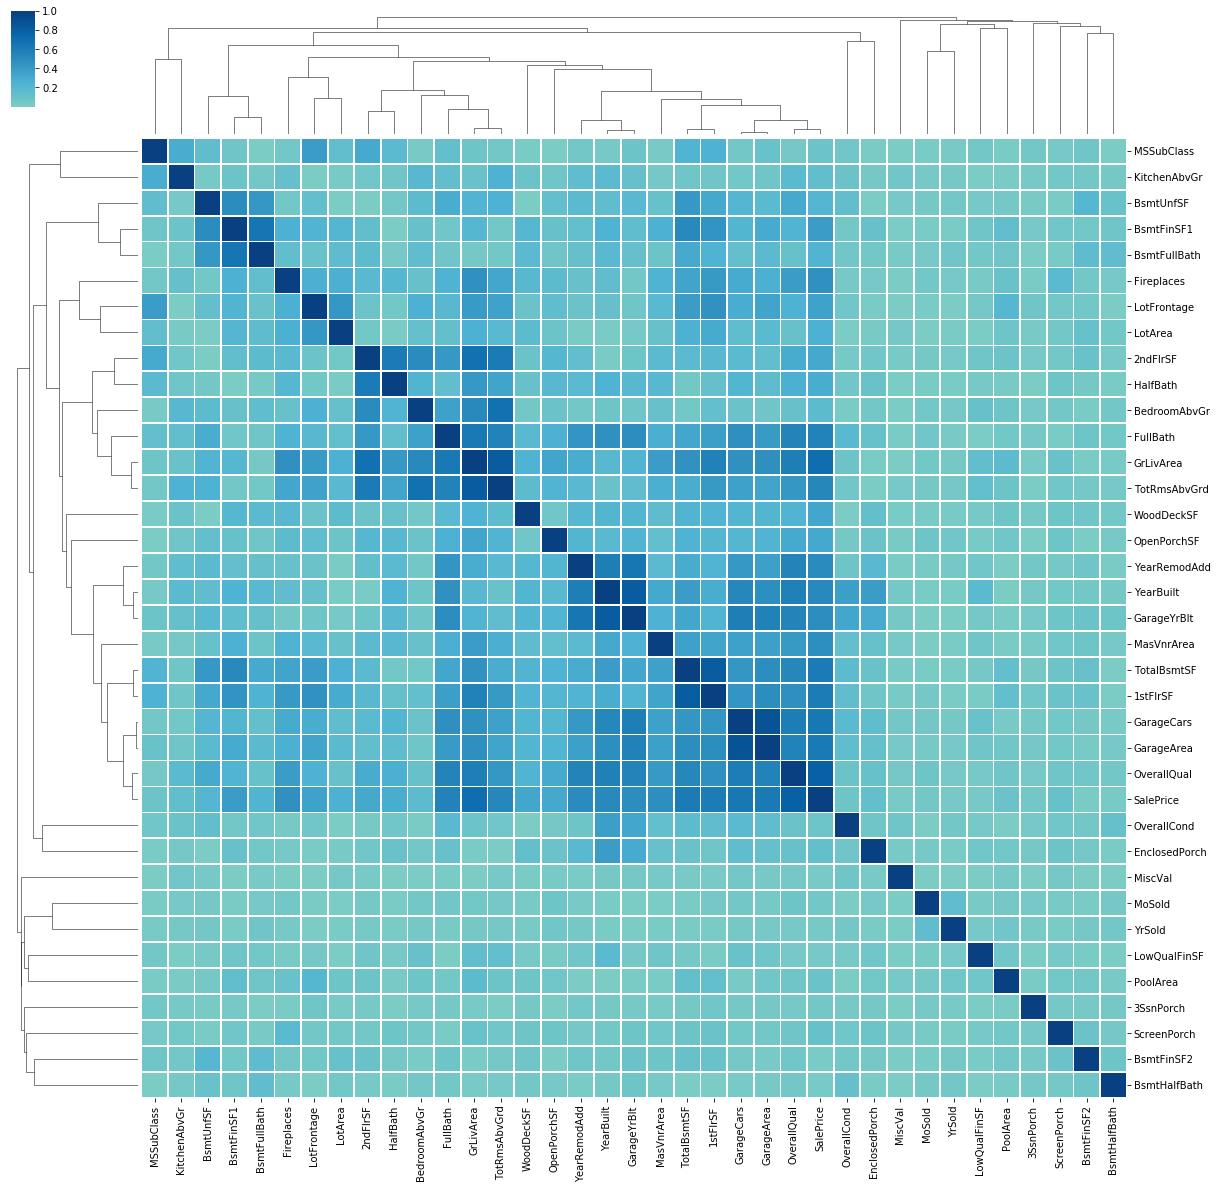

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

In [77]:
correlation = train_df.corr().abs()
sns.clustermap(correlation, center=0, cmap="GnBu", linewidths=.75, figsize=(20,20), metric="correlation")
plt.show()

display(correlation.loc["SalePrice"].sort_values(ascending=False))

As there are a lot of features to analyse, I like to begin by looking at what are the most relevant features. But this only includes numerical features. We have to perform feature engineering on object features do discover weither they are relevant or not.
<p style="text-align:justify">Now we know what are the most important features to predict the price of our houses. This ranking comes with no surprises as all these features give a general description of the house. But this only include the numerical features. We still need to study all the features whith a dtype of "object".</p>
<ul>
    <li><b>OverallQual:</b> Rates the overall material and finish of the house</li>
    <li><b>GrLivArea:</b> Above grade (ground) living area square feet</li>
    <li><b>GarageCars:</b> Size of garage in car capacity</li>
    <li><b>GarageArea:</b> Size of garage in square feet</li>
    <li><b>TotalBsmtSF:</b> Total square feet of basement area</li>
    <li><b>1stFlrSF:</b> First Floor square feet</li>
    <li><b>FullBath:</b> Full bathrooms above grade</li>
    <li><b>TotRmsAbvGrd:</b> Total rooms above grade (does not include bathrooms)</li>
    <li><b>YearBuilt:</b> Original construction date</li>
    <li><b>YearRemodAdd:</b> Remodel date (same as construction date if no remodeling or additions)</li>
</ul>

### Type of features

In [118]:
types = set([train_df[col].dtype for col in train_df.columns])
nbr_types = []
for values in types:
    print("Number of {} features: {}".format(values, len(train_df.select_dtypes(include=values).columns)))
obj_features = set([col for col in train_df.columns if train_df[col].dtype == "object"]) 

isnull = pd.concat([train_df, test_df]).isnull().any(axis=0)
set([isnull.index[col] for col in range(len(isnull)) if isnull[col]]) - obj_features

Number of object features: 43
Number of float64 features: 4
Number of int64 features: 33


{'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'SalePrice',
 'TotalBsmtSF'}

We have 37 numerical features that we will be able to exploit as such. But we will need to convert the categorical features.

### Missing datas<a id="missing_datas"></a>

In [83]:
len([col for col in train_df.columns if train_df[col].dtype == "object"])

43

In [84]:
train_missing = (train_df.isnull().sum()/len(train_df)*100)
test_missing = (test_df.isnull().sum()/len(test_df)*100)
pd.concat([train_missing, test_missing, correlation.loc["SalePrice"]], axis=1, keys=["Train missing", "Test missing", "Correlation"]).sort_values("Test missing", ascending=False).head(34)

,Train missing,Test missing,Correlation
PoolQC,99.520548,99.794380,NaN
MiscFeature,96.301370,96.504455,NaN
Alley,93.767123,92.666210,NaN
Fence,80.753425,80.123372,NaN
FireplaceQu,47.260274,50.034270,NaN
LotFrontage,17.739726,15.558602,0.351799
GarageQual,5.547945,5.346127,NaN
GarageFinish,5.547945,5.346127,NaN
GarageCond,5.547945,5.346127,NaN
GarageYrBlt,5.547945,5.346127,0.486362


<p style="text-align:justify;">Missing datas are an important part of our datasets. We will need to do some feature engineering to complete these datasets with informations that fit the example the most. <br>We are goig to drop all the features that have more than 15% missing datas, because they do not carry enought information to make appropriate decisions. Also these features are not what buyers are looking at when they are looking for a new house to buy. Thus we can drop these features without worrying. Now we have 27 features to complete.</p>
<ul>
    <li><b>PoolQC:</b> Pool quality</li>
    <li><b>MiscFeature:</b> Miscellaneous feature not covered in other categories</li>
    <li><b>Alley:</b> Type of alley access to property</li>
    <li><b>Fence:</b> Fence quality</li>
    <li><b>FireplaceQu:</b> Fireplace quality</li>
</ul>

In [13]:
features_to_drop = [col for col in train_missing.index if train_missing[col]>20]
for dataset in full:
    dataset.drop(features_to_drop, axis=1, inplace=True)
print("The following features were drop for having too much missing datas:")
display(features_to_drop)

The following features were drop for having too much missing datas:


['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

### Basement features

First of all, let's display all the features related to the basement.

In [14]:
basements = [col for col in train_df.columns if "Bsmt" in col]

Then let's have a look at how many missing datas there is for each of these features.

In [15]:
for feature in basements:
    print("{}({}): \t{} missing train \t{} missing test".format(feature, train_df[feature].dtype, train_df[feature].isnull().sum(), test_df[feature].isnull().sum()))

BsmtQual(object): 	37 missing train 	44 missing test
BsmtCond(object): 	37 missing train 	45 missing test
BsmtExposure(object): 	38 missing train 	44 missing test
BsmtFinType1(object): 	37 missing train 	42 missing test
BsmtFinSF1(int64): 	0 missing train 	1 missing test
BsmtFinType2(object): 	38 missing train 	42 missing test
BsmtFinSF2(int64): 	0 missing train 	1 missing test
BsmtUnfSF(int64): 	0 missing train 	1 missing test
TotalBsmtSF(int64): 	0 missing train 	1 missing test
BsmtFullBath(int64): 	0 missing train 	2 missing test
BsmtHalfBath(int64): 	0 missing train 	2 missing test


In [16]:
obj_features = [col for col in basements if train_df[col].dtype == "object"]
obj_features

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

Let's take the training dataset. The problem is: we have 37 missing features for 3 objects and 38 missing features for 2 other objects. All the int64 features have no missing features.<br>
We need to complete the objects using the int64. But we have a difference between our objects, we need first to see what are the two examples which are different.

In [17]:
train_df[train_df[["BsmtExposure", "BsmtFinType2"]].isnull().any(axis=1)][train_df["BsmtQual"].notnull()][basements]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,1,0
948,Gd,TA,NaN,Unf,0,Unf,0,936,936,0,0


In [18]:
train_df[basements] = train_df[basements].set_value([332], "BsmtFinType2", train_df["BsmtFinType2"].describe().top)
train_df[basements] = train_df[basements].set_value([948], "BsmtExposure", train_df["BsmtExposure"].describe().top)

In [19]:
train_df[train_df[obj_features].isnull().any(axis=1)]["TotalBsmtSF"].sum()

0

In [20]:
train_df[basements] = train_df[basements].fillna("NA")

For the test dataset, we have a lot of different cases... Let's reduce 45 to 44. If we take a look at this formula to see if we can simply replace eveerything with NA, we see that it is not possible. We will need to be more carefull in our feature engineering.

In [21]:
test_df[test_df[obj_features].isnull().any(axis=1)]["TotalBsmtSF"].sum()

6397.0

In [22]:
problem = test_df[test_df["BsmtCond"].isnull()][test_df["BsmtFinType1"].notnull()][basements]
display(problem)
indexes = problem.index

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


In [23]:
top = test_df["BsmtCond"].describe().top
test_df[basements] = test_df[basements].set_value(indexes, "BsmtCond", top)

In [24]:
test_df[test_df[["BsmtQual", "BsmtExposure"]].isnull().any(axis=1)][test_df["BsmtCond"].notnull()][basements]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
27,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0
888,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0


In [25]:
top_qual = test_df["BsmtQual"].describe().top
top_exposure = test_df["BsmtExposure"].describe().top

test_df[basements] = test_df[basements].set_value([757], "BsmtQual", top_qual)
test_df[basements] = test_df[basements].set_value([758], "BsmtQual", top_qual)
test_df[basements] = test_df[basements].set_value([27], "BsmtExposure", top_exposure)
test_df[basements] = test_df[basements].set_value([888], "BsmtExposure", top_exposure)

In [26]:
test_df[test_df[[col for col in basements if test_df[col].dtype != "object"]].isnull().any(axis=1)][basements]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [27]:
for feature in [col for col in basements if test_df[col].dtype != "object"]:
    test_df[basements] = test_df[basements].set_value([660], feature, 0)
    test_df[basements] = test_df[basements].set_value([728], feature, 0)

In [28]:
test_df[test_df[obj_features].isnull().any(axis=1)][test_df["TotalBsmtSF"].notnull()][["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]].sum().sum()

0.0

In [29]:
test_df[basements] = test_df[basements].fillna("NA")

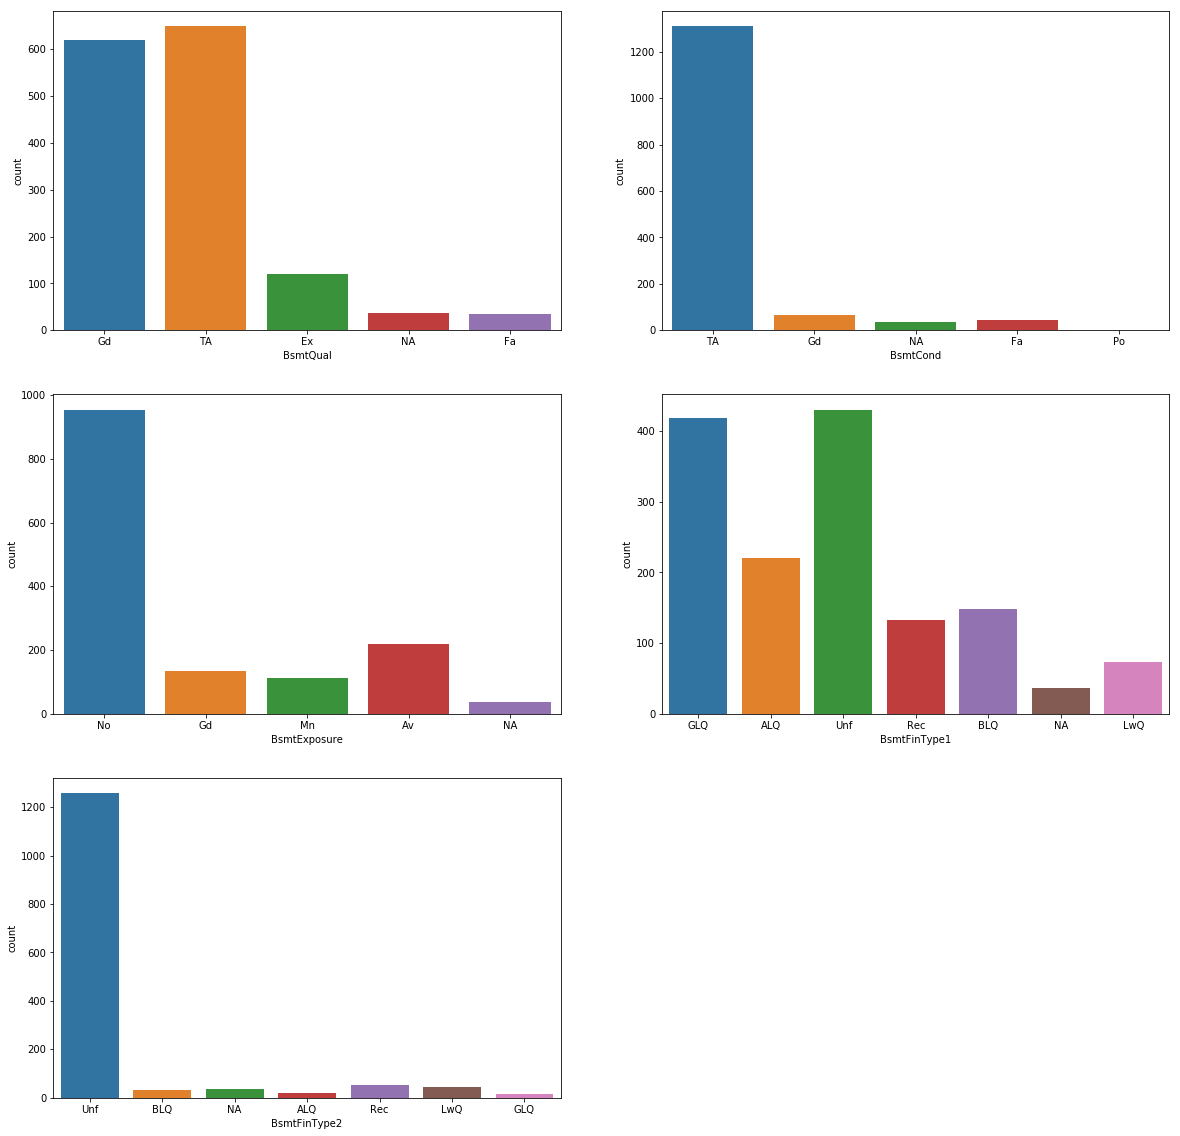

In [30]:
fig = plt.figure(figsize=(20,20))

for i in range(1, len(obj_features)+1):
    ax1 = fig.add_subplot(3, 2, i)
    sns.countplot(obj_features[i-1], data=train_df)
plt.show()

In [31]:
full_dict = {
    "BsmtQual": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0
    },
    "BsmtCond": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0
    },
    "BsmtExposure": {
        "Gd": 4,
        "Av": 3,
        "Mn": 2,
        "No": 1,
        "NA": 0
    },
    "BsmtFinType1": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0
    },
    "BsmtFinType2": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0
    }
}

In [32]:
for feature in obj_features:
    train_df[feature] = train_df[feature].map(full_dict[feature])
    test_df[feature] = test_df[feature].map(full_dict[feature])

### Garage related features

First let's collect all the features that are related to the garage.

In [33]:
garages = [col for col in train_df.columns if col.startswith('Garage')]
display(garages)

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

Now let's examine what how many missing datas there are for each of these features.

In [34]:
for feature in garages:
    print("{}({}): \t{} missing train \t{} missing test".format(feature, train_df[feature].dtype, train_df[feature].isnull().sum(), test_df[feature].isnull().sum()))

GarageType(object): 	81 missing train 	76 missing test
GarageYrBlt(float64): 	81 missing train 	78 missing test
GarageFinish(object): 	81 missing train 	78 missing test
GarageCars(int64): 	0 missing train 	1 missing test
GarageArea(int64): 	0 missing train 	1 missing test
GarageQual(object): 	81 missing train 	78 missing test
GarageCond(object): 	81 missing train 	78 missing test


Before completting these features we can examine something. We have no missing datas for the training dataset for GarageCars feature and only one missing for the test dataset. With this feature only, we can understand weither there is a garage or not.

In [35]:
obj_features = [col for col in garages if train_df[col].dtype == "object"]
print("There is a garage {}".format(train_df[train_df[obj_features].isnull().any(axis=1)]["GarageCars"].sum()))
print("There is a garage {}".format(test_df[test_df[obj_features].isnull().any(axis=1)]["GarageCars"].sum()))

There is a garage 0
There is a garage 1.0


For the training dataset there is no garage for all the object features which are missing datas, we can complete them with NA value (no garage). For the test dataset we have one problem, let's examine it.

In [36]:
test_df[test_df["GarageCars"].isnull()][garages]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In this case, we can see from the first feature that there is a garage, but we have no informations about it... So I decided to complete the object features with the top values for each feature. The GarageCars feature will be completed with the mean value for this feature.

We can assume that the year the garage was built is the same year as the year the house was built.

In [37]:
test_df[test_df["GarageCars"].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,70,RM,50.0,9060,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,212,0,0,0,0,3,2007,WD,Alloca


In [38]:
full_df = pd.concat([train_df, test_df])
for feature in obj_features:
    test_df[feature] = test_df[test_df["GarageCars"].isnull()][feature].fillna(full_df[feature].describe().top)
test_df["GarageArea"][1116] = int(full_df["GarageArea"].mean())
test_df["GarageCars"][1116] = int(full_df["GarageCars"].mean())

In [39]:
test_df[test_df["GarageCars"].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [40]:
for dataset in full:
    dataset["GarageYrBlt"] = dataset["GarageYrBlt"].fillna(dataset["YearBuilt"])
    for feature in obj_features:
        dataset[feature] = dataset[feature].fillna("NA")

In [41]:
for k in range(len(obj_features)):
    print(k)

0
1
2
3


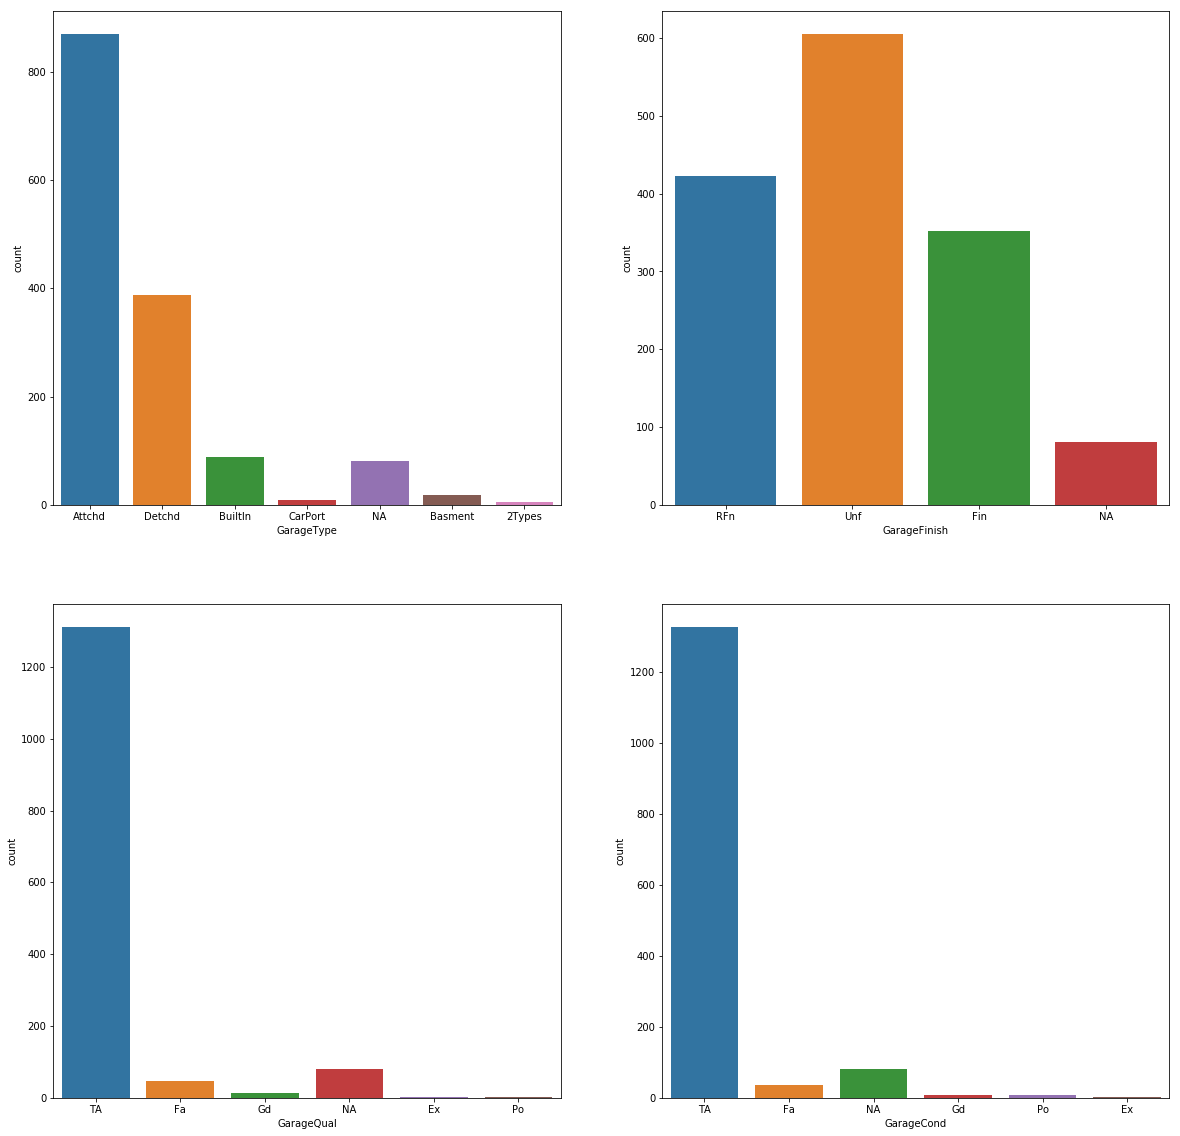

In [42]:
fig = plt.figure(figsize=(20,20))

for axe in range(1, len(obj_features)+1):
    ax1 = fig.add_subplot(2,2,axe)
    sns.countplot(x=obj_features[axe-1], data=train_df)

plt.show()

In [43]:
full_dict = {
    "GarageType": {
        "2Types": 6,
        "Attchd": 5,
        "Basment": 4,
        "BuiltIn": 3,
        "CarPort": 2,
        "Detchd": 1,
        "NA": 0
    },
    "GarageFinish": {
        "Fin": 3,
        "RFn": 2,
        "Unf": 1,
        "NA": 0
    },
    "GarageQual": {
        "Ex":5,
        "Gd":4,
        "TA":3,
        "Fa":2,
        "Po":1,
        "NA":0
    },
    "GarageCond": {
        "Ex":5,
        "Gd":4,
        "TA":3,
        "Fa":2,
        "Po":1,
        "NA":0
    }
}

In [44]:
for feature in garages:
    if train_df[feature].dtype == "object":
        top = full_df[feature].describe().top
        
        for dataset in full:
            dataset[feature] = dataset[feature].fillna(top)
            dataset[feature] = dataset[feature].map(full_dict[feature])            
            
        print("{} filled with {}".format(feature, top))

GarageType filled with Attchd
GarageFinish filled with Unf
GarageQual filled with TA
GarageCond filled with TA


<div class="alert alert-info"><b>GarageType:</b> Garage location<br>

<ul>
    <li>2Types: More than one type of garage</li>
    <li>Attchd: Attached to home</li>
    <li>Basment: Basement Garage</li>
    <li>BuiltIn: Built-In (Garage part of house - typically has room above garage)<br>
    <li>CarPort: Car Port<br>
    <li>Detchd: Detached from home</li>
    <li>NA: No Garage</li>
</ul></div>

<div class="alert alert-info"><b>GarageYrBlt: </b>Year garage was built</div>

<div class="alert alert-info"><b>GarageFinish:</b> Interior finish of the garage<br>

<ul>
    <li>Fin: Finished</li>
    <li>RFn: Rough Finished</li>
    <li>Unf: Unfinished</li>
    <li>NA: No Garage</li>
</ul></div>

<div class="alert alert-info"><b>GarageCars:</b> Size of garage in car capacity</div>

<div class="alert alert-info"><b>GarageArea:</b> Size of garage in square feet</div>

<div class="alert alert-info"><b>GarageQual:</b> Garage quality<br>

<ul>
       <li>Ex: Excellent</li>
       <li>Gd: Good</li>
       <li>TA:  Typical/Average</li>
       <li>Fa:	Fair<br>
       <li>Po:	Poor<br>
    <li>NA:	No Garage</li></ul></div>

<div class="alert alert-info"><b>GarageCond:</b> Garage condition<br>

<ul>
    <li>Ex: Excellent</li>
    <li>Gd: Good</li>
    <li>TA: Typical/Average</li>
    <li>Fa: Fair</li>
    <li>Po: Poor</li>
    <li>NA: No Garage</li>
</ul></div>        

### Lot Frontage

<div class="alert alert-info"><b>LotFrontage:</b> Linear feet of street connected to property</div>

In [2]:
fig = plt.figure(figsize=(20,8))

(mu, sigma) = st.norm.fit(train_df["LotFrontage"].dropna())
ax1 = fig.add_subplot(1, 2, 1)
sns.distplot(train_df["LotFrontage"].dropna(), fit=st.norm, ax=ax1)
ax1.legend(["Normal distribution ($\mu$= {:.2f}, $\sigma$={:.2f})".format(mu, sigma)], loc="best", prop={"size": 16})
plt.title("Distribution of LotFrontage", fontsize=25)
plt.xlabel("LotFrontage", fontsize=20)
plt.ylabel("Frequency", fontsize=20)

ax2 = fig.add_subplot(1, 2, 2)
st.probplot(train_df["SalePrice"], plot=ax2)
plt.title("Probability Plot", fontsize=25)
plt.xlabel("Theorical quantities", fontsize=20)
plt.ylabel("Ordered Values", fontsize=20)

plt.show()



#print("The skewness is equal to: {} %".format(st.skew(train_df["LotFrontage"])))
#print("The kurtosis is equal to: {} %".format(st.kurtosis(train_df["LotFrontage"]))

NameError: name 'plt' is not defined

In [54]:
train_df["LotFrontage"].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [60]:
display(correlation.loc["LotFrontage"].sort_values(ascending=False).head(10))

LotFrontage     1.000000
1stFlrSF        0.457181
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
MSSubClass      0.386347
SalePrice       0.355878
TotRmsAbvGrd    0.352096
GarageArea      0.344997
GarageCars      0.285691
Name: LotFrontage, dtype: float64

### Usefull functions

In [78]:
def draw_distribution(feature_name):
    fig = plt.figure(figsize=(20,8))

    (mu, sigma) = st.norm.fit(train_df[feature_name])

    ax1 = fig.add_subplot(1, 2, 1)
    sns.distplot(train_df[feature_name], fit=st.norm, ax=ax1)
    ax1.legend(["Normal distribution ($\mu$= {:.2f}, $\sigma$={:.2f})".format(mu, sigma)], loc="best", prop={"size": 16})
    plt.title("Distribution of {}".format(feature_name), fontsize=25)
    plt.xlabel(feature_name, fontsize=20)
    plt.ylabel("Frequency", fontsize=20)

    ax2 = fig.add_subplot(1, 2, 2)
    st.probplot(train_df["SalePrice"], plot=ax2)
    plt.title("Probability Plot", fontsize=25)
    plt.xlabel("Theorical quantities", fontsize=20)
    plt.ylabel("Ordered Values", fontsize=20)
    plt.show()

    print("The skewness is equal to: {} %".format(st.skew(train_df[feature_name])))
    print("The kurtosis is equal to: {} %".format(st.kurtosis(train_df[feature_name])))

### Sale Price<a id="sale_price"></a>
The SalePrice is the target of our dataset. Let's take a quick look at it.

In [79]:
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

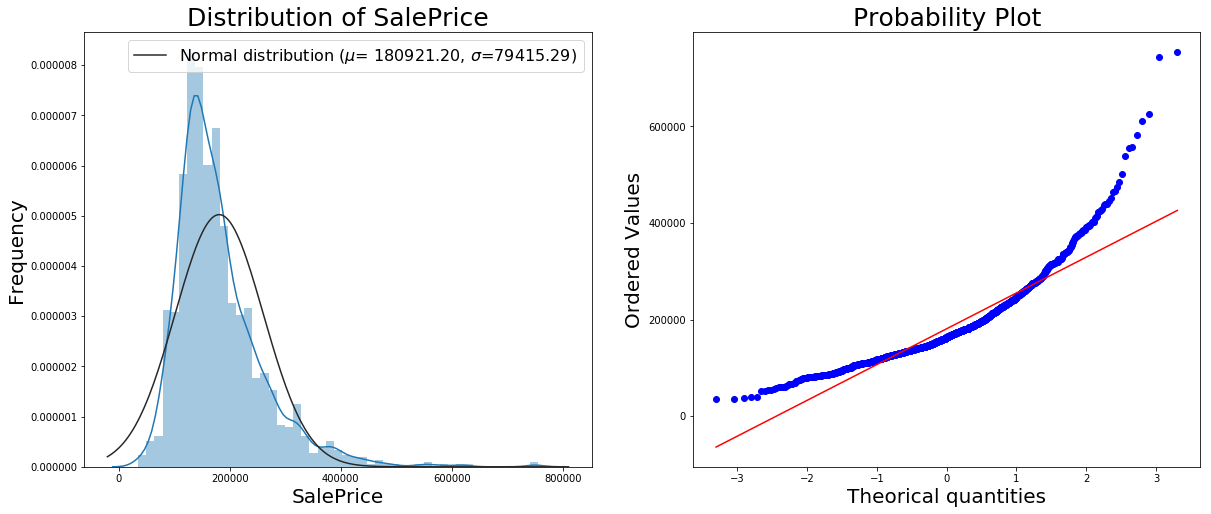

The skewness is equal to: 1.880940746034036 %
The kurtosis is equal to: 6.509812011089439 %


In [80]:
draw_distribution("SalePrice")

<p style="text-align:justify;">By plotting these graphs we can see that the distribution of the SalePrice feature does not follow a normal distribution. To improve the efficiency of our algorithm, we will need to do some modifications on this feature to get it to fit more a normal distribution. Let's try this:</p>

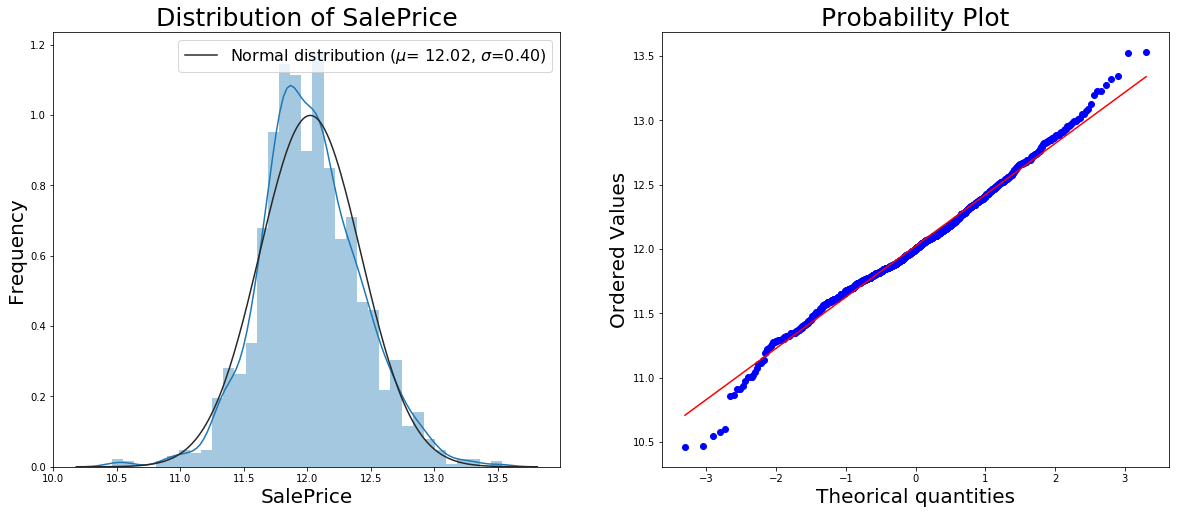

The skewness is equal to: 0.1212103673013655 %
The kurtosis is equal to: 0.8026555069117713 %


In [81]:
train_df.SalePrice = np.log(train_df.SalePrice)
draw_distribution("SalePrice")

This is better, we will keep it like that.